In [1]:
import pandas as pd
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


def rename(df):
    df = df.rename(columns={
        "/'Untitled'/'Micr1'": 'Micr1',
        "/'Untitled'/'Acc1X'": 'Acc1X',
        "/'Untitled'/'Acc1Y'": 'Acc1Y',
        "/'Untitled'/'Acc1Z'": 'Acc1Z',
        "/'Untitled'/'Acc5X'": 'Acc5X',
        "/'Untitled'/'Acc5Y'": 'Acc5Y',
        "/'Untitled'/'Acc5Z'": 'Acc5Z',
        "/'Untitled'/'Acc1L'": 'Acc1L',
        "/'Untitled'/'Acc3X'": 'Acc3X',
        "/'Untitled'/'Acc3Y'": 'Acc3Y',
        "/'Untitled'/'Acc3Z'": 'Acc3Z',
        "/'Untitled'/'Acc3L'": 'Acc3L',
        "/'Untitled'/'Acc5L'": 'Acc5L',
        "/'Untitled'/'Acc2L'": 'Acc2L',
        "/'Untitled'/'Acc4L'": 'Acc4L',
        "/'Untitled'/'Mems3'": 'Mems3',
        "/'Untitled'/'Curr1'": 'Curr1',
        "/'Untitled'/'Curr2'": 'Curr2',
        "/'Untitled'/'Curr3'": 'Curr3',
        "/'Untitled'/'Mems5X'": 'Mems5X',
        "/'Untitled'/'Mems5Y'": 'Mems5Y',
        "/'Untitled'/'Mems5Z'": 'Mems5Z',
        "/'Untitled'/'SlowShaftTrigger'": 'SlowShaftTrigger'
    })
    return df

def createPandasDF(df):
    df = df.dropna()
    df = rename(df)
    df = df.drop(df.columns[-1], axis=1)
    return df

def toBinned(df):

    bin_size = 440
    
    # Initialize an empty dictionary to store binning results for each column
    binned_data = {}
    
    # Iterate over all columns to bin
    for col in df.columns:
        # Perform binning by grouping by bin_size
        binned_col = df[col].groupby(df.index // bin_size)
        
        # Calculate statistics for each bin
        binned_stats = binned_col.agg(['mean', 'skew', 'var'])
        
        # Rename resulting columns based on the column and metric used
        binned_stats.columns = [f'{col}_{stat}_binned' for stat in ['mean', 'skew', 'var']]
        
        # Add results to the dictionary
        binned_data[col] = binned_stats
    
    # Create a complete dataframe with all binned columns
    binned_df = pd.concat(binned_data.values(), axis=1)
    
    return binned_df


In [2]:
def df_from_path(file_paths):
    # Create an empty list for DataFrames
    df_out = []

    # Iterate over each TDMS file and create the corresponding DataFrame
    for file_path in file_paths:
        full_path = '/belt_Tests/Data' + file_path  
        tdms_file = TdmsFile.read(full_path)
        df = tdms_file.as_dataframe()
        df = createPandasDF(df)
        df_out.append(df)
    df_output = pd.concat(df_out, ignore_index=True)
    return df_output

# List of TDMS files that I'm gonna use to train the model
file_paths_nom = [
    "/Nominal/04_data_Test01_0074_sampled.tdms",
    "/Nominal/08_data_Test05_0010_sampled.tdms",
    "/Nominal/15_data_Test12_0005_sampled.tdms",
    "/Nominal/16_data_Test26_0010_sampled.tdms",
    "/Nominal/data_Test01_0044_sampled.tdms",
    "/Nominal/data_Test05_0001_sampled.tdms",
    "/Nominal/data_Test13_0008_Nominal_sampled.tdms", 
    "/Nominal/data_Test40_0033_Nominal_sampled.tdms",
    "/Nominal/data_Test39_0005_sampled.tdms",
    "/Nominal/data_Test44_0011_sampled.tdms",
]

file_paths_Loops = [
    "/Loops/data_Test02_0004_sampled.tdms",
    "/Loops/data_Test03_0005_sampled.tdms",
    "/Loops/data_Test04_0006_sampled.tdms",
    "/Loops/data_Test08_0005_sampled.tdms",
    "/Loops/data_Test08_0006_sampled.tdms",
    "/Loops/data_Test11_0007_sampled.tdms",
    "/Loops/data_Test15_0008_sampled.tdms",
    "/Loops/data_Test19_0008_sampled.tdms",
    "/Loops/data_Test21_0002_sampled.tdms",
    
]

file_paths_Chain = [
    "/Chain/data_Test41_0003_cat1_sampled.tdms",
    "/Chain/data_Test41_0009_Chain_1mm_sampled.tdms", 
    "/Chain/data_Test42_0004_Chain_2mm_sampled.tdms",
    "/Chain/data_Test43_0002_cat5_sampled.tdms",
]

file_paths_Ties = [
    "/Ties/data_Test27_0001_sampled.tdms",
    "/Ties/data_Test27_0009_sampled.tdms",
    "/Ties/data_Test28_0002_sampled.tdms",
    "/Ties/data_Test29_0003_sampled.tdms",
    "/Ties/data_Test30_0004_sampled.tdms",
    "/Ties/data_Test31_0003_sampled.tdms",
    "/Ties/data_Test31_0008_sampled.tdms",
    "/Ties/data_Test32_0006_sampled.tdms",
    "/Ties/data_Test32_0008_sampled.tdms",
    "/Ties/data_Test33_0001_sampled.tdms",
    "/Ties/data_Test33_0002_sampled.tdms",
    "/Ties/data_Test34_0008_sampled.tdms",
    "/Ties/data_Test35_0009_sampled.tdms",
    "/Ties/data_Test36_0009_sampled.tdms",
    "/Ties/data_Test37_0003_sampled.tdms",
]

def addError(df, error):
    if error:
        df['Error'] = 1
    else: df['Error'] = 0
    return df

df_Nominal = df_from_path(file_paths_nom)
binned_nom = toBinned(df_Nominal)
binned_nom = addError(binned_nom, error = False)

df_Loops = df_from_path(file_paths_Loops)
binned_Loops = toBinned(df_Loops)
binned_Loops = addError(binned_Loops, True)

df_Chain = df_from_path(file_paths_Chain)
binned_Chain = toBinned(df_Chain)
binned_Chain = addError(binned_Chain,True)

df_Ties = df_from_path(file_paths_Ties)
binned_Ties = toBinned(df_Ties)
binned_Ties = addError(binned_Ties,True)

def checkLength(df,dim):
    maxDim = len(df)
    if dim < 0:
        print("Error: the dimension of the dataframe cannot be negative!")
        return df, 0
    elif dim >= maxDim:
        return df, maxDim
    else: return df, dim
        
    
def concat_DF(binned_nom, dimNom, binned_Loops, dimLoops, binned_Chain, dimChain, binned_Ties, dimTies):
    binned_nom, dimNom = checkLength(binned_nom, dimNom)
    binned_Loops, dimLoops = checkLength(binned_Loops, dimLoops)
    binned_Chain, dimChain = checkLength(binned_Chain, dimChain)
    binned_Ties, dimTies = checkLength(binned_Ties, dimTies)

    concatenated_df = pd.concat([binned_nom.head(dimNom), binned_Loops.head(dimLoops), binned_Chain.head(dimChain), binned_Ties.head(dimTies)], axis=0)
    concatenated_df.reset_index(drop=True, inplace=True)
    
    return concatenated_df


dimNom = 13596       #Max = 13596
dimLoops = 99999    #Max = 10079
dimChain = 99999    #Max = 5455
dimTies = 99999  #Max = 20455
concatenated_DF = concat_DF(binned_nom, dimNom, binned_Loops, dimLoops, binned_Chain, dimChain, binned_Ties, dimTies)



In [5]:
concatenated_DF

,Micr1_mean_binned,Micr1_skew_binned,Micr1_var_binned,Acc1X_mean_binned,Acc1X_skew_binned,Acc1X_var_binned,Acc1Y_mean_binned,Acc1Y_skew_binned,Acc1Y_var_binned,Acc1Z_mean_binned,...,Mems5X_mean_binned,Mems5X_skew_binned,Mems5X_var_binned,Mems5Y_mean_binned,Mems5Y_skew_binned,Mems5Y_var_binned,Mems5Z_mean_binned,Mems5Z_skew_binned,Mems5Z_var_binned,Error
0,-0.004816,0.051653,4.143655,0.056115,-0.267702,0.719684,0.001682,0.450708,7.264728,0.009020,...,1.602516,0.070839,0.001780,1.653408,0.209117,0.001568,1.687857,0.680014,0.002475,0
1,0.057922,0.221297,3.347931,0.054229,-0.145160,1.087754,-0.019580,-0.138556,9.608789,0.022354,...,1.600227,0.104360,0.002110,1.653089,-0.114436,0.001484,1.685153,0.473613,0.002309,0
2,0.061762,-0.011147,3.545638,0.054216,0.201121,0.737336,0.048800,-0.420234,4.609882,0.014063,...,1.603398,0.242082,0.001713,1.656134,-0.279470,0.001528,1.694615,0.122532,0.002174,0
3,0.070155,-0.083714,4.332263,0.056790,-0.004932,0.700795,0.018749,-0.358628,8.233508,0.006768,...,1.597323,-0.274674,0.001587,1.649379,-0.084064,0.001402,1.680295,0.248782,0.002342,0
4,0.092257,-0.081737,3.935596,0.057864,-0.264635,0.832335,-0.013152,0.149603,6.612272,0.012578,...,1.602242,-0.207498,0.002128,1.653789,-0.051933,0.001448,1.688669,0.240088,0.002595,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49580,-0.120196,-0.013659,3.546483,0.045707,-0.892035,0.846870,0.011761,-0.790011,4.553095,0.018357,...,1.601506,-0.140025,0.001507,1.653998,0.265479,0.000780,1.688502,0.676706,0.000390,1
49581,-0.204270,-0.078290,3.663386,0.047415,0.006660,0.721450,-0.015649,0.347861,7.223919,0.016105,...,1.600857,-0.073355,0.002287,1.654328,0.222200,0.000847,1.688481,-0.084744,0.000463,1
49582,0.097258,-0.005709,3.475474,0.046167,0.080302,0.838228,-0.013593,-1.292963,11.854933,0.010976,...,1.600876,0.110467,0.002068,1.653207,0.173113,0.000609,1.687209,-0.440460,0.000406,1
49583,0.205695,0.134289,3.781502,0.045732,-0.158313,0.606287,-0.011448,0.091116,5.726041,0.015507,...,1.600891,-0.269945,0.001712,1.654279,0.200055,0.000763,1.689279,0.157232,0.000431,1


In [7]:
from sklearn.model_selection import train_test_split

# Separate the target variable (Error) from the other features of the dataframe.
X = concatenated_DF.drop('Error', axis=1)
y = concatenated_DF['Error']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state =1984)

In [8]:
X_train


,Micr1_mean_binned,Micr1_skew_binned,Micr1_var_binned,Acc1X_mean_binned,Acc1X_skew_binned,Acc1X_var_binned,Acc1Y_mean_binned,Acc1Y_skew_binned,Acc1Y_var_binned,Acc1Z_mean_binned,...,Curr3_var_binned,Mems5X_mean_binned,Mems5X_skew_binned,Mems5X_var_binned,Mems5Y_mean_binned,Mems5Y_skew_binned,Mems5Y_var_binned,Mems5Z_mean_binned,Mems5Z_skew_binned,Mems5Z_var_binned
25793,0.071637,0.094035,4.374311,0.055705,0.098888,0.669847,0.034495,0.029097,7.966358,0.008578,...,0.001579,1.600529,-0.160073,0.001624,1.652616,0.370822,0.000788,1.687903,-0.013538,0.000550
14357,-0.044106,-0.376459,4.384407,0.051386,0.148517,1.235245,0.046440,-0.933653,7.746092,0.006399,...,0.001575,1.598894,-0.018856,0.002005,1.650431,0.089524,0.001714,1.679650,-0.085903,0.002284
15620,0.137475,-0.048821,3.349801,0.047647,-0.309106,0.753470,0.043908,1.082322,5.579879,-0.017917,...,0.001506,1.602647,-0.059854,0.002585,1.654725,0.183348,0.001773,1.691608,0.197564,0.002213
10988,0.257709,-0.125600,4.156038,0.056455,0.012344,1.005996,-0.003458,-0.814634,5.161129,-0.000240,...,0.001696,1.601159,-0.032411,0.002396,1.654010,0.131157,0.001656,1.688836,-0.217511,0.000402
48478,0.035106,-0.041245,3.440878,0.053779,-0.157061,0.789361,-0.001518,0.107133,7.994401,0.008304,...,0.001552,1.601175,-0.195372,0.001602,1.654006,0.282308,0.000716,1.688893,0.474191,0.000474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37960,0.179735,-0.070622,3.545582,0.042666,-0.318118,0.897428,-0.016969,-0.714937,5.539173,0.011934,...,0.001429,1.601975,-0.393452,0.002227,1.655189,0.239183,0.000979,1.688349,0.559673,0.001214
10009,-0.059764,-0.353036,4.028986,0.051028,-0.195224,0.784857,-0.026147,-0.082728,8.926531,0.018620,...,0.001636,1.600775,-0.111300,0.001850,1.652535,0.134729,0.000998,1.687809,0.559765,0.000526
1779,-0.130296,0.034122,3.435643,0.055864,-0.308474,1.028630,0.024231,-0.392298,4.229510,0.014800,...,0.001519,1.600980,-0.320209,0.001887,1.653263,0.080006,0.001449,1.686603,0.010971,0.002395
38655,0.082377,-0.054999,3.492467,0.043022,-0.312043,0.706234,-0.012278,-1.228449,5.897006,0.008013,...,0.001460,1.600840,-0.328519,0.001993,1.652904,0.321674,0.001219,1.686481,0.273727,0.001061


In [9]:
y_train

25793    1
14357    1
15620    1
10988    0
48478    1
        ..
37960    1
10009    0
1779     0
38655    1
30319    1
Name: Error, Length: 34709, dtype: int64

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier  
import xgboost as xgb
from sklearn.metrics import classification_report
import time
from joblib import dump, load


In [7]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_score': make_scorer(f1_score, average='macro', zero_division=0)
}


In [8]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = RandomForestClassifier(random_state=42)

model 1

param_grid_xgb = {

    'n_estimators': [30, 80, 130, 170],
    
    'learning_rate': [0.01, 0.1, 0.2],
    
    'max_depth': [4, 6, 5, 10, 20],
    
    'min_child_weight': [1, 5],
    
    'colsample_bytree': [0.8, 1.0],
}


param_grid_rf = {

    'n_estimators': [30, 50, 100, 200],  
    'max_depth': [2, 3, 5, 10, 20, 40],  
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2],  
}


In [9]:
#xgb1 accuracy
param_grid_xgb = {
    'n_estimators': [30, 80, 130, 170],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 5, 10, 20],
    'min_child_weight': [1, 5],
    'colsample_bytree': [0.8, 1.0],
}

start_time = time.time()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring=scorers, refit='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Saving the model in local to use it with load
dump(best_model, 'Best_model_xgbA1.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=30; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=130; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=30; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=30; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=80; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=170; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=30; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimato

/Users/albertotrenta/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The model took  28.283 minutes to train.
Migliori parametri: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 170}
Migliore score: 0.9006598854708686
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4044
           1       0.91      0.96      0.93     10832

    accuracy                           0.90     14876
   macro avg       0.89      0.86      0.87     14876
weighted avg       0.90      0.90      0.90     14876



In [10]:
#f1_score
param_grid_xgb = {
    'n_estimators': [30, 80, 130, 170],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 5, 10, 20],
    'min_child_weight': [1, 5],
    'colsample_bytree': [0.8, 1.0],
}

start_time = time.time()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring=scorers, refit='f1_score', verbose=1)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'Best_model_xgb1F1.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=130; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=30; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=80; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=130; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=30; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=80; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimato

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=170; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=30; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=80; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=170; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=30; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=130; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=170; total time=   7.3s
[CV] END colsample_bytree=0.8, learn

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=130; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=30; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=80; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=130; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=30; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=80; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=170; total time=   7.9s
[CV] END colsample_bytree=0.8, learni

/Users/albertotrenta/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=30; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=170; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=80; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=170; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=80; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=130; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=30; total time=   1.9s
[CV] END colsample_bytree=0.8, learni

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=30; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=130; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=170; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=130; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=170; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=130; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=30; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=30; total time=   1.9s
[CV] END colsample_bytree=0.8, lear

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=170; total time=   7.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=80; total time=  34.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=130; total time=  35.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=80; total time=  11.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=130; total time=  11.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=30; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=30; total time=   0.9s
[CV] END colsample_bytree=1.0, learning

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=30; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=170; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=130; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=170; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=80; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=170; total time=   7.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=80; total time=   3.6s
[CV] END colsample_bytree=0.8, learn

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=30; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=130; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=170; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=130; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=30; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=80; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=130; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=30; total time=   1.9s
[CV] END colsample_bytree=0.8, learn

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=130; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=170; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=30; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=80; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=130; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=30; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=80; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=170; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=30; total time=  20.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=130; total time=  37.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=170; total time=  28.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=170; total time=  11.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=130; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=170; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=80; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=130; total time=   1.8s
[CV] END colsample_bytree=0.8, learnin

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=130; total time=  23.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=80; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=130; total time=   8.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=170; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=130; total time=   1.8s
[CV] END colsample_bytree=0.8, learn

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=130; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=170; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=30; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=80; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=130; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=170; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=130; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=30; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rat

The model took  20.569 minutes to train.
Migliori parametri: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 170}
Migliore score: 0.8704589077530871
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4044
           1       0.91      0.96      0.93     10832

    accuracy                           0.90     14876
   macro avg       0.89      0.86      0.87     14876
weighted avg       0.90      0.90      0.90     14876



In [14]:
#accuracy
param_grid_rf = {
    'n_estimators': [30, 50, 100, 200],  
    'max_depth': [2, 3, 5, 10, 20, 40],  
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2],  
}

start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring=scorers, refit='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'Best_model_rfA1.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
The model took  21.183 minutes to train.
Migliori parametri: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Migliore score: 0.890287956551601
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      4044
           1       0.89      0.97      0.93     10832

    accuracy                           0.89     14876
   macro avg       0.89      0.83      0.85     14876
weighted avg       0.89      0.89      0.89     14876



In [15]:
#f1_score
param_grid_rf = {
    'n_estimators': [30, 50, 100, 200],  
    'max_depth': [2, 3, 5, 10, 20, 40],  
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2],  
}

start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring=scorers, refit='f1_score', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_rf1F1.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
The model took  21.299 minutes to train.
Migliori parametri: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Migliore score: 0.8513185371707153
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      4044
           1       0.89      0.97      0.93     10832

    accuracy                           0.89     14876
   macro avg       0.89      0.83      0.85     14876
weighted avg       0.89      0.89      0.89     14876



Seconda Test
param_grid_rf2 = {

    'n_estimators': [30, 50, 100],  
    'max_depth': [2, 3, 5, 10],  
    'min_samples_split': [1,2,3],  
    'min_samples_leaf': [1, 2,3],  
}

ho ridotto il numero di alberi, e la profondità, ma con uno split e leaf in più

param_grid_xgb2 = {

    'n_estimators': [30, 60, 80, 90],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1,2,3],
    'min_child_weight': [1,2,3],
    'colsample_bytree': [0.8, 1.0],
}

ho ridotto il numero di stimatori e diminuito il learning rate

In [16]:
#accuracy 2
param_grid_rf2 = {
    'n_estimators': [30, 50, 100],  
    'max_depth': [2, 3, 5, 10],  
    'min_samples_split': [1,2,3],  
    'min_samples_leaf': [1, 2,3],  
}

start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf2, cv=5, n_jobs=-1, scoring=scorers, refit='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_rfA2.joblib')


y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
The model took  8.634 minutes to train.
Migliori parametri: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Migliore score: 0.8743843809104943
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4044
           1       0.86      0.98      0.92     10832

    accuracy                           0.87     14876
   macro avg       0.89      0.78      0.81     14876
weighted avg       0.88      0.87      0.86     14876



In [17]:
#f1_score 2

start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf2, cv=5, n_jobs=-1, scoring=scorers, refit='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_rf2f1.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
The model took  8.819 minutes to train.
Migliori parametri: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Migliore score: 0.8743843809104943
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4044
           1       0.86      0.98      0.92     10832

    accuracy                           0.87     14876
   macro avg       0.89      0.78      0.81     14876
weighted avg       0.88      0.87      0.86     14876



In [18]:
param_grid_xgb2 = {
    'n_estimators': [30, 60, 80, 90],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1,2,3],
    'min_child_weight': [1,2,3],
    'colsample_bytree': [0.8, 1.0],
}

start_time = time.time()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb2, cv=5, n_jobs=-1, scoring=scorers, refit='f1_score', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_xgb2F1.joblib')


y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
The model took  2.266 minutes to train.
Migliori parametri: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 90}
Migliore score: 0.8329268176726382
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      4044
           1       0.88      0.96      0.92     10832

    accuracy                           0.87     14876
   macro avg       0.87      0.80      0.83     14876
weighted avg       0.87      0.87      0.87     14876



In [19]:

start_time = time.time()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb2, cv=5, n_jobs=-1, scoring=scorers, refit='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_xgbA2.joblib')


y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=80; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=170; total time=   6.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=30; total time=  23.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=130; total time=  36.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=30; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=30; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimato

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   3.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   3.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=30; total time=   3.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=  12.9s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=30; total time=   3.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   6.4s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=170; total time=   7.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=80; total time=  33.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=130; total time=  34.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=80; total time=   7.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=130; total time=  10.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=30; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=30; total time=   0.8s
[CV] END colsample_bytree=0.8, learning

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=170; total time=  10.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=130; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=170; total time=   7.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=80; total time=  34.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=1, n_estimators=170; total time=  35.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=80; total time=   7.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=130; total time=  10.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=170; total time=  11.1s
[CV] END colsample_bytree=0.8, lea

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=170; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=170; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=80; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=130; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=170; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=170; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=30; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=130; total time=  14.6s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=130; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=170; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=80; total time=  22.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=130; total time=  18.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=30; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=80; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=130; total time=   7.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=30; total time=   0.9s
[CV] END colsample_bytree=1.0, learn

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=130; total time=   8.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=30; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=30; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=80; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=130; total time=   5.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=170; total time=   7.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=80; total time=  20.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=170; total time=  25.5s
[CV] END colsample_bytree=1.0, learn

The model took  2.153 minutes to train.
Migliori parametri: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 90}
Migliore score: 0.8761992662275787
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      4044
           1       0.88      0.96      0.92     10832

    accuracy                           0.87     14876
   macro avg       0.87      0.80      0.83     14876
weighted avg       0.87      0.87      0.87     14876



In [20]:
#f1_score cv 10

start_time = time.time()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb2, cv=10, n_jobs=-1, scoring=scorers, refit='f1_score', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_xgbf1_cv10.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=170; total time=  10.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=130; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=170; total time=   7.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=80; total time=  17.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=130; total time=  23.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=80; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estim

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=130; total time=   8.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=170; total time=  10.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=170; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=80; total time=  14.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=1, n_estimators=130; total time=  23.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=30; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=30; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=20, min_child_weight=5, n_estimators=80; total time=   6.9s
[CV] END colsample_bytree=1.0, learn

The model took  4.674 minutes to train.
Migliori parametri: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 90}
Migliore score: 0.8309092400621602
              precision    recall  f1-score   support

           0       0.86      0.63      0.73      4044
           1       0.88      0.96      0.92     10832

    accuracy                           0.87     14876
   macro avg       0.87      0.80      0.82     14876
weighted avg       0.87      0.87      0.87     14876



In [21]:
#f1_score cv 10

start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=10, n_jobs=-1, scoring=scorers, refit='f1_score', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_rf_f1_cv10.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
The model took  46.344 minutes to train.
Migliori parametri: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Migliore score: 0.8521262361060755
              precision    recall  f1-score   support

           0       0.89      0.67      0.77      4044
           1       0.89      0.97      0.93     10832

    accuracy                           0.89     14876
   macro avg       0.89      0.82      0.85     14876
weighted avg       0.89      0.89      0.88     14876



In [1]:
#CV = 15
param_grid_xgb = {
    'n_estimators': [30, 60, 80, 90],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1,2,3],
    'min_child_weight': [1,2,3],
    'colsample_bytree': [0.8, 1.0],
}
start_time = time.time()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb2, cv=15, n_jobs=-1, scoring=scorers, refit='f1_score', verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time/60: .3f} minutes to train.")

print("best parameters:", grid_search.best_params_)
print("best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
dump(best_model, 'best_model_xgbf1_cv15.joblib')

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

NameError: name 'time' is not defined

In [11]:
model1 = load('best_model_rfA1.joblib')
mod1 = "RF 1 A"
model2 = load('best_model_rfA2.joblib')
mod2 = "RF 2 A"
model3 = load('best_model_rf1F1.joblib')
mod3 = "RF 1 F1"
model4 = load('best_model_xgb2F1.joblib')
mod4 = "XGB 2 F1"
model5 = load('best_model_xgbA1.joblib')
mod5 = "XGB 1 A"
model6 = load('best_model_xgbA2.joblib')
mod6 = "XGB 2 A"
model7 = load('best_model_xgb1F1.joblib')
mod7 = "XGB 1 F1"
model8 = load('best_model_rf2f1.joblib')
mod8 = "XGB 2 F1"
model9 = load('best_model_rf_f1_cv10.joblib')
mod9 = "RF F1 CV10"
model10 = load('best_model_xgbf1_cv10.joblib')
mod10 = "XGB F1 CV10"
model11 = load('best_model_xgbf1_cv15.joblib')
mod11 = "XGB F1 CV15"


models_un_bin = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11]
names = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9, mod10, mod11]

model1_balanced = load('best_model_rf1F1_balanced.joblib')
model2_balanced = load('best_model_rf1A_balanced.joblib')
model3_balanced = load('best_model_rf2f1_balanced.joblib')
model4_balanced = load('best_model_rf2A_balanced.joblib')
model5_balanced = load('best_model_xgbA1_balanced.joblib')
model6_balanced = load('best_model_xgbF11_balanced.joblib')
model7_balanced = load('best_model_xgbA2_balanced.joblib')
model8_balanced = load('best_model_xgb2F1_balanced.joblib')
model9_balanced = load('best_model_rf1_cv10_balanced.joblib')
model10_balanced = load('best_model_xgb_cv10_balanced.joblib')
model11_balanced = load('best_model_xgbf1_cv15_balanced.joblib')

mod1_bal= 'RF1 F1 BAL'
mod2_bal = 'RF1 A1 BAL'
mod3_bal = 'RF2 F1 BAL' 
mod4_bal = 'RF2 A BAL' 
mod5_bal = 'XGB1 A BAL' 
mod6_bal = 'XGB1 F1 BAL' 
mod7_bal = 'XGB2 A BAL' 
mod8_bal = 'XGB2 F1 BAL'
mod9_bal = 'RF1 CV10 BAL'
mod10_bal = 'XGB F1 CV10 BAL'
mod11_bal = 'XGB F1 CV15 BAL'

names_bal = [mod1_bal, mod2_bal, mod3_bal, mod4_bal, mod5_bal, mod6_bal, mod7_bal, mod8_bal, mod9_bal, mod10_bal, mod11_bal]
                
models_balanced_bin = [model1_balanced, #RF1 F1
                    model2_balanced, #RF1 A
                    model3_balanced, #RF2 F1
                    model4_balanced, #RF2 A
                    model5_balanced, #XGB1 A
                    model6_balanced, #XGB1 F1
                    model7_balanced, #XGB2 A
                    model8_balanced, #XGB2 F1
                    model9_balanced, #RF1 CV10
                    model10_balanced, #XGB F1 CV10
                    model11_balanced #XGB F1 CV15
                   ]

In [13]:
# Remove target raw (Error) from features
X_Test = concatenated_DF.drop('Error', axis=1)
X_Test

,Micr1_mean_binned,Micr1_skew_binned,Micr1_var_binned,Acc1X_mean_binned,Acc1X_skew_binned,Acc1X_var_binned,Acc1Y_mean_binned,Acc1Y_skew_binned,Acc1Y_var_binned,Acc1Z_mean_binned,...,Curr3_var_binned,Mems5X_mean_binned,Mems5X_skew_binned,Mems5X_var_binned,Mems5Y_mean_binned,Mems5Y_skew_binned,Mems5Y_var_binned,Mems5Z_mean_binned,Mems5Z_skew_binned,Mems5Z_var_binned
0,-0.004816,0.051653,4.143655,0.056115,-0.267702,0.719684,0.001682,0.450708,7.264728,0.009020,...,0.001505,1.602516,0.070839,0.001780,1.653408,0.209117,0.001568,1.687857,0.680014,0.002475
1,0.057922,0.221297,3.347931,0.054229,-0.145160,1.087754,-0.019580,-0.138556,9.608789,0.022354,...,0.001444,1.600227,0.104360,0.002110,1.653089,-0.114436,0.001484,1.685153,0.473613,0.002309
2,0.061762,-0.011147,3.545638,0.054216,0.201121,0.737336,0.048800,-0.420234,4.609882,0.014063,...,0.001358,1.603398,0.242082,0.001713,1.656134,-0.279470,0.001528,1.694615,0.122532,0.002174
3,0.070155,-0.083714,4.332263,0.056790,-0.004932,0.700795,0.018749,-0.358628,8.233508,0.006768,...,0.001498,1.597323,-0.274674,0.001587,1.649379,-0.084064,0.001402,1.680295,0.248782,0.002342
4,0.092257,-0.081737,3.935596,0.057864,-0.264635,0.832335,-0.013152,0.149603,6.612272,0.012578,...,0.001485,1.602242,-0.207498,0.002128,1.653789,-0.051933,0.001448,1.688669,0.240088,0.002595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49580,-0.120196,-0.013659,3.546483,0.045707,-0.892035,0.846870,0.011761,-0.790011,4.553095,0.018357,...,0.001571,1.601506,-0.140025,0.001507,1.653998,0.265479,0.000780,1.688502,0.676706,0.000390
49581,-0.204270,-0.078290,3.663386,0.047415,0.006660,0.721450,-0.015649,0.347861,7.223919,0.016105,...,0.001473,1.600857,-0.073355,0.002287,1.654328,0.222200,0.000847,1.688481,-0.084744,0.000463
49582,0.097258,-0.005709,3.475474,0.046167,0.080302,0.838228,-0.013593,-1.292963,11.854933,0.010976,...,0.001435,1.600876,0.110467,0.002068,1.653207,0.173113,0.000609,1.687209,-0.440460,0.000406
49583,0.205695,0.134289,3.781502,0.045732,-0.158313,0.606287,-0.011448,0.091116,5.726041,0.015507,...,0.001558,1.600891,-0.269945,0.001712,1.654279,0.200055,0.000763,1.689279,0.157232,0.000431


In [17]:
# Libraries for data manipulation
import pandas as pd
from nptdms import TdmsFile
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for model evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# machine learning algorithms
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Other Libraries
import time
from joblib import dump, load


Classification Report for model 1: 
RF 1 A
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     13596
           1       0.97      0.99      0.98     35989

    accuracy                           0.97     49585
   macro avg       0.97      0.95      0.96     49585
weighted avg       0.97      0.97      0.97     49585

Confusion Matrix
[[12304  1292]
 [  316 35673]]


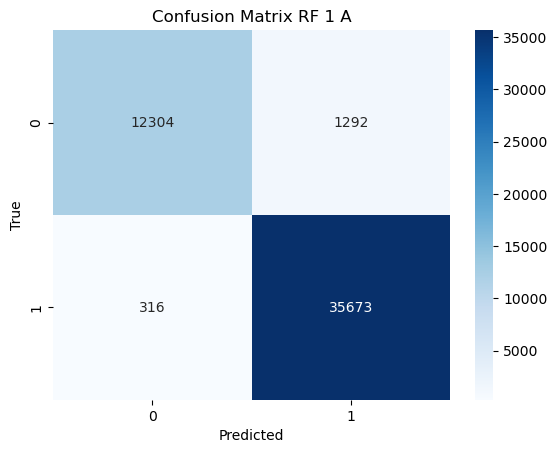

Classification Report for model 2: 
RF 2 A
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     13596
           1       0.88      0.99      0.93     35989

    accuracy                           0.90     49585
   macro avg       0.92      0.82      0.85     49585
weighted avg       0.90      0.90      0.89     49585

Confusion Matrix
[[ 8724  4872]
 [  313 35676]]


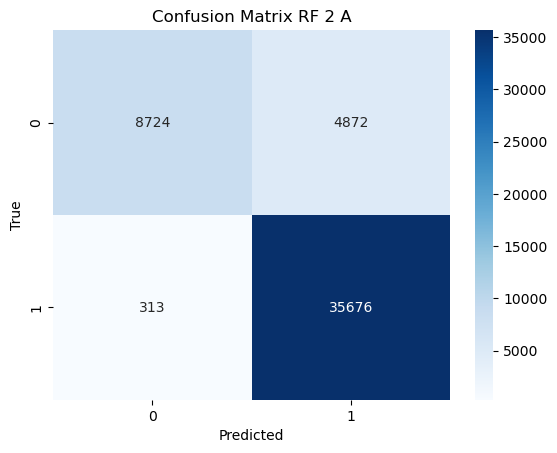

Classification Report for model 3: 
RF 1 F1
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     13596
           1       0.97      0.99      0.98     35989

    accuracy                           0.97     49585
   macro avg       0.97      0.95      0.96     49585
weighted avg       0.97      0.97      0.97     49585

Confusion Matrix
[[12304  1292]
 [  316 35673]]


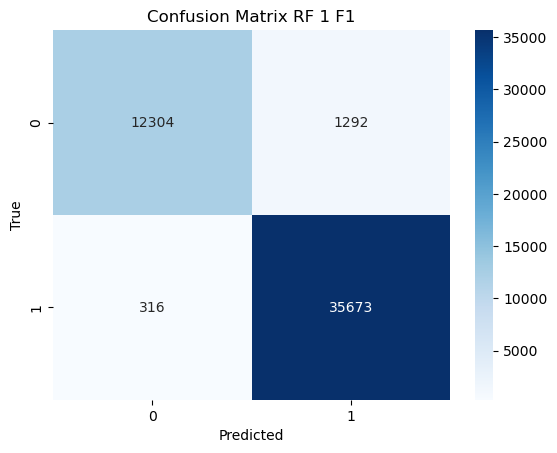

Classification Report for model 4: 
XGB 2 F1
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     13596
           1       0.88      0.96      0.92     35989

    accuracy                           0.88     49585
   macro avg       0.87      0.81      0.84     49585
weighted avg       0.88      0.88      0.88     49585

Confusion Matrix
[[ 9085  4511]
 [ 1425 34564]]


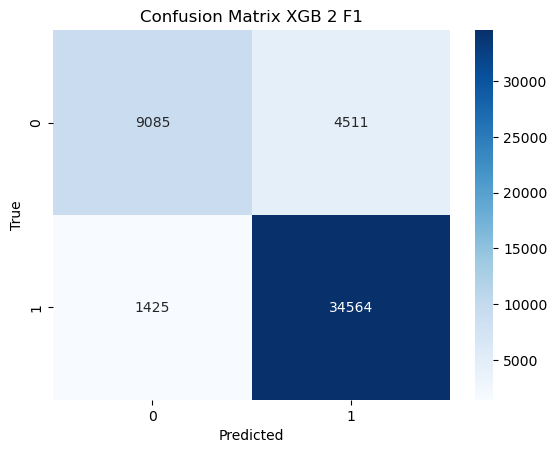

Classification Report for model 5: 
XGB 1 A
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     13596
           1       0.97      0.99      0.98     35989

    accuracy                           0.97     49585
   macro avg       0.97      0.95      0.96     49585
weighted avg       0.97      0.97      0.97     49585

Confusion Matrix
[[12531  1065]
 [  487 35502]]


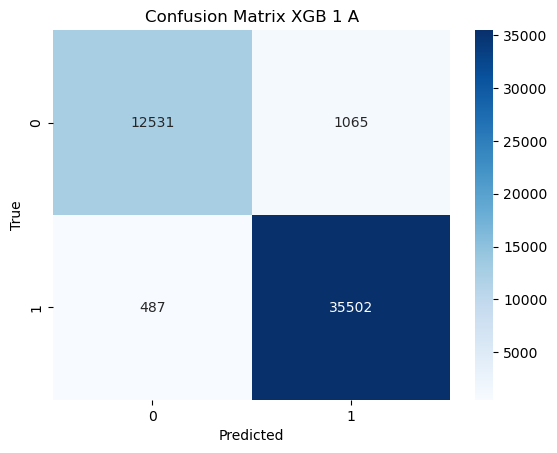

Classification Report for model 6: 
XGB 2 A
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     13596
           1       0.88      0.96      0.92     35989

    accuracy                           0.88     49585
   macro avg       0.87      0.81      0.84     49585
weighted avg       0.88      0.88      0.88     49585

Confusion Matrix
[[ 9085  4511]
 [ 1425 34564]]


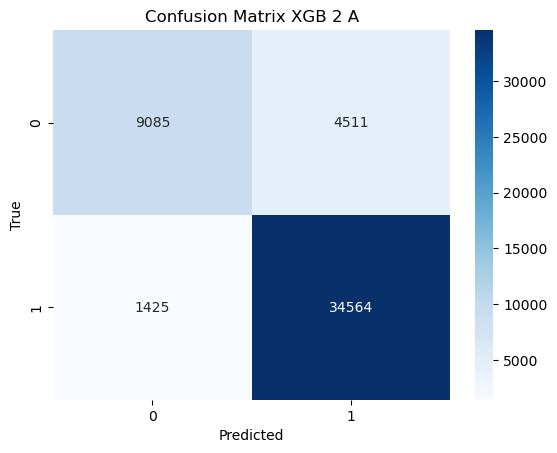

Classification Report for model 7: 
XGB 1 F1
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     13596
           1       0.97      0.99      0.98     35989

    accuracy                           0.97     49585
   macro avg       0.97      0.95      0.96     49585
weighted avg       0.97      0.97      0.97     49585

Confusion Matrix
[[12531  1065]
 [  487 35502]]


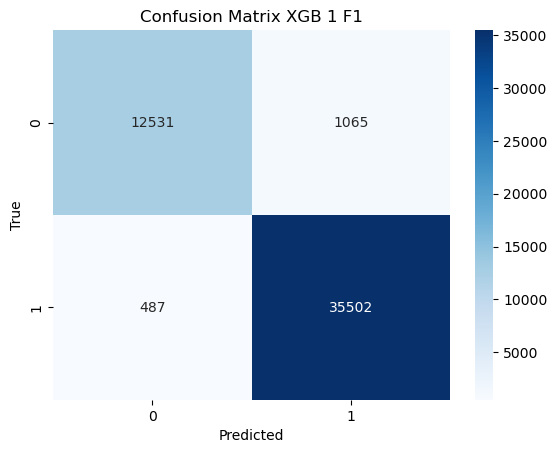

Classification Report for model 8: 
XGB 2 F1
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     13596
           1       0.88      0.99      0.93     35989

    accuracy                           0.90     49585
   macro avg       0.92      0.82      0.85     49585
weighted avg       0.90      0.90      0.89     49585

Confusion Matrix
[[ 8724  4872]
 [  313 35676]]


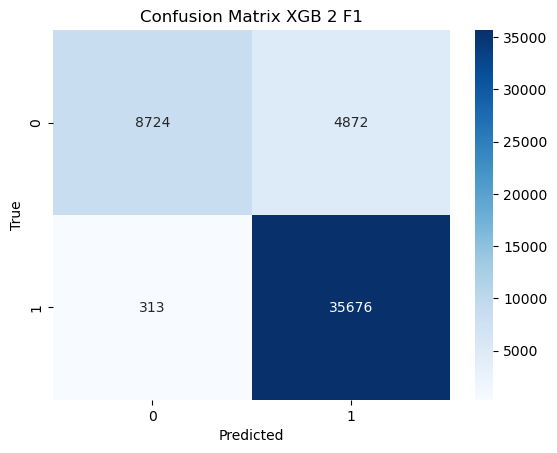

Classification Report for model 9: 
RF F1 CV10
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     13596
           1       0.96      0.99      0.98     35989

    accuracy                           0.97     49585
   macro avg       0.97      0.95      0.96     49585
weighted avg       0.97      0.97      0.97     49585

Confusion Matrix
[[12273  1323]
 [  341 35648]]


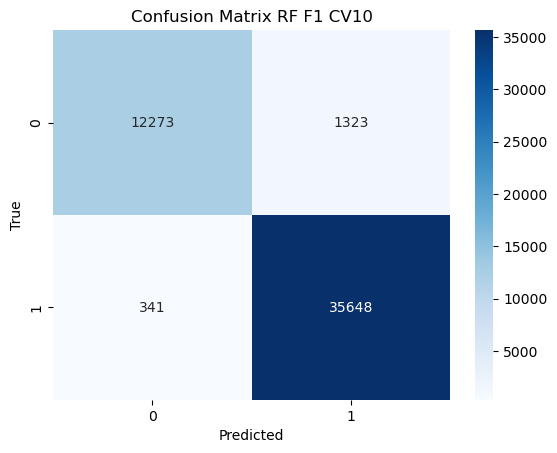

Classification Report for model 10: 
XGB F1 CV10
              precision    recall  f1-score   support

           0       0.87      0.66      0.75     13596
           1       0.88      0.96      0.92     35989

    accuracy                           0.88     49585
   macro avg       0.87      0.81      0.83     49585
weighted avg       0.88      0.88      0.87     49585

Confusion Matrix
[[ 8956  4640]
 [ 1387 34602]]


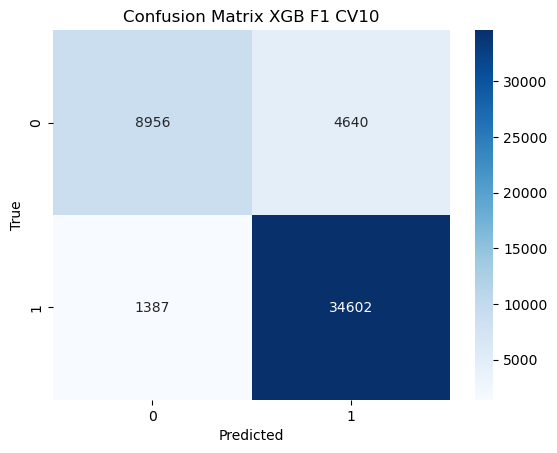

Classification Report for model 11: 
XGB F1 CV15
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     13596
           1       0.88      0.96      0.92     35989

    accuracy                           0.88     49585
   macro avg       0.87      0.81      0.84     49585
weighted avg       0.88      0.88      0.88     49585

Confusion Matrix
[[ 9085  4511]
 [ 1425 34564]]


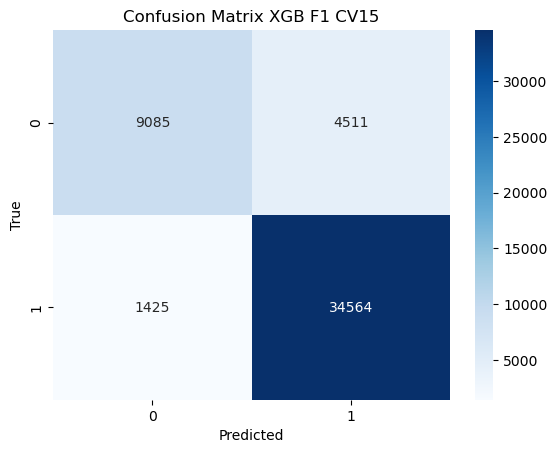

In [18]:
i = 0
for model in models_un_bin:

      predictions = model.predict(X_Test)

    report_Test = classification_report(concatenated_DF['Error'], predictions)

    print(f"Classification Report for model {i+1}: \n{names[i]}")
    print(report_Test)
    
    confusion_mat = confusion_matrix(concatenated_DF['Error'], predictions)
    print("Confusion Matrix")
    print(confusion_mat)

    plt.figure()
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {names[i]}')
    plt.show()
    i+=1

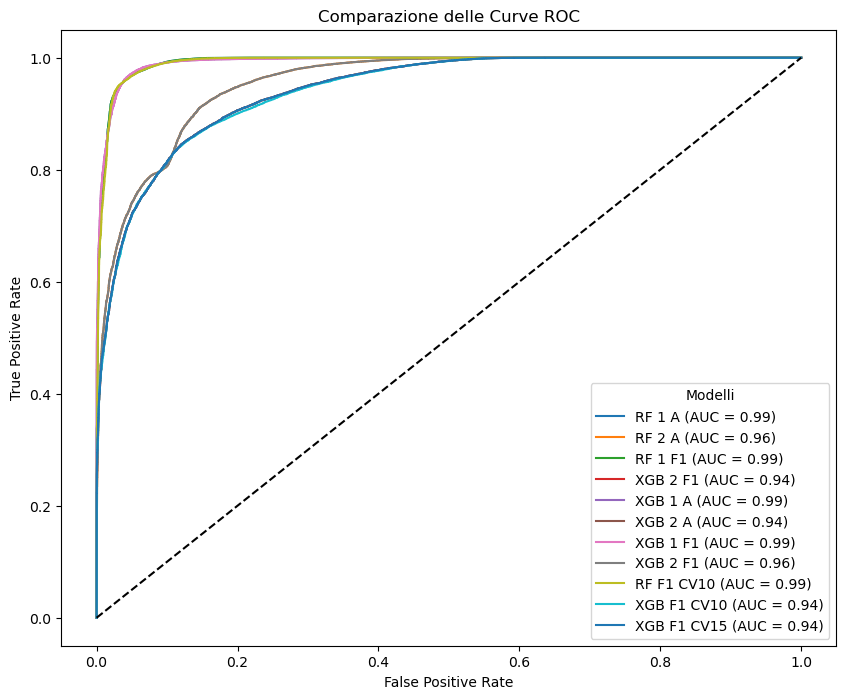

In [26]:
from sklearn.metrics import roc_curve, auc

model_names = []

plt.figure(figsize=(10, 8))

# Loop on the models
i = 0
for model in models_un_bin:
    # predictions for positive class
    y_proba = model.predict_proba(X_Test)[:, 1]

    # Calcolate FPR, TPR, e AUC
    fpr, tpr, thresholds = roc_curve(concatenated_DF['Error'], y_proba)
    roc_auc = auc(fpr, tpr)

    # Add model name to the lista
    model_names.append(f"model {i+1} (AUC = {roc_auc:.2f})")

    # Add ROC curve to the graph
    plt.plot(fpr, tpr, label=f'{names[i]} (AUC = {roc_auc:.2f})')
    i += 1

# add casual line for reference
plt.plot([0, 1], [0, 1], 'k--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparazione delle Curve ROC')
plt.legend(title="models")
plt.show()


Classification Report - Modello 1
RF1 F1 BAL
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     13596
           1       0.96      0.99      0.98     35989

    accuracy                           0.97     49585
   macro avg       0.97      0.94      0.96     49585
weighted avg       0.97      0.97      0.96     49585

Confusion Matrix
[[12240  1356]
 [  371 35618]]


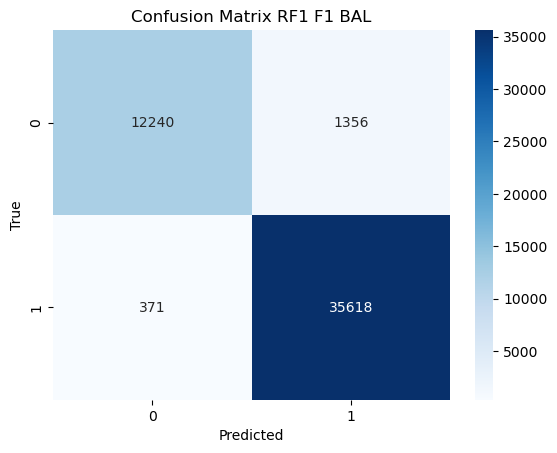

Classification Report - Modello 2
RF1 A1 BAL
              precision    recall  f1-score   support

           0       0.74      0.96      0.83     13596
           1       0.98      0.87      0.92     35989

    accuracy                           0.90     49585
   macro avg       0.86      0.91      0.88     49585
weighted avg       0.92      0.90      0.90     49585

Confusion Matrix
[[13012   584]
 [ 4578 31411]]


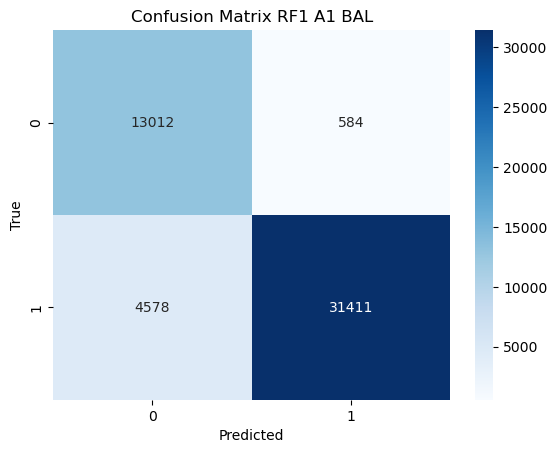

Classification Report - Modello 3
RF2 F1 BAL
              precision    recall  f1-score   support

           0       0.66      0.90      0.76     13596
           1       0.95      0.82      0.88     35989

    accuracy                           0.84     49585
   macro avg       0.81      0.86      0.82     49585
weighted avg       0.87      0.84      0.85     49585

Confusion Matrix
[[12169  1427]
 [ 6369 29620]]


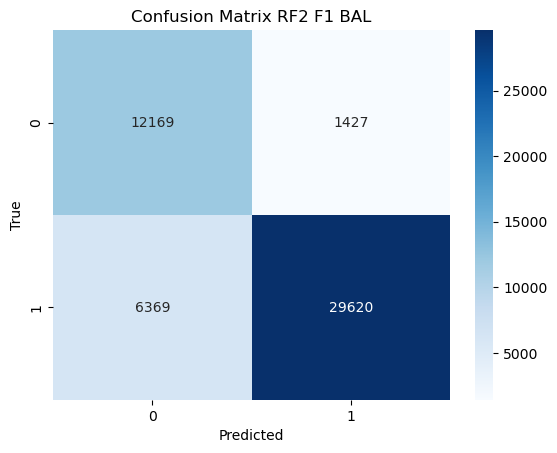

Classification Report - Modello 4
RF2 A BAL
              precision    recall  f1-score   support

           0       0.66      0.90      0.76     13596
           1       0.95      0.82      0.88     35989

    accuracy                           0.84     49585
   macro avg       0.81      0.86      0.82     49585
weighted avg       0.87      0.84      0.85     49585

Confusion Matrix
[[12169  1427]
 [ 6369 29620]]


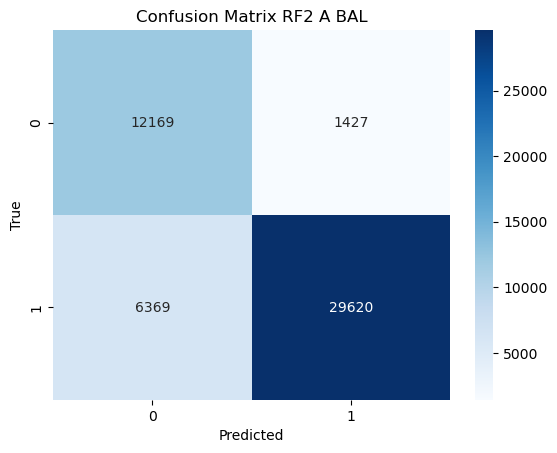

Classification Report - Modello 5
XGB1 A BAL
              precision    recall  f1-score   support

           0       0.75      0.96      0.84     13596
           1       0.98      0.88      0.93     35989

    accuracy                           0.90     49585
   macro avg       0.87      0.92      0.89     49585
weighted avg       0.92      0.90      0.90     49585

Confusion Matrix
[[13007   589]
 [ 4291 31698]]


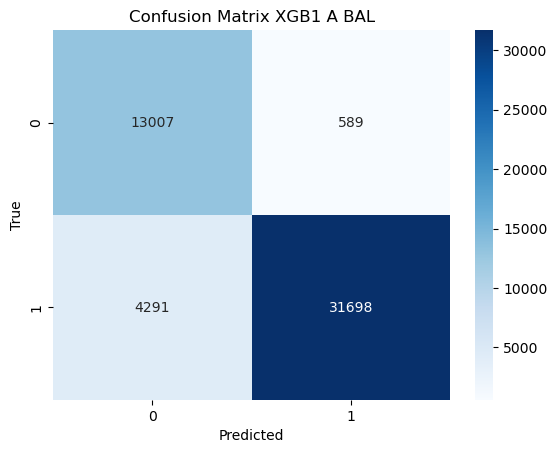

Classification Report - Modello 6
XGB1 F1 BAL
              precision    recall  f1-score   support

           0       0.75      0.96      0.84     13596
           1       0.98      0.88      0.93     35989

    accuracy                           0.90     49585
   macro avg       0.87      0.92      0.89     49585
weighted avg       0.92      0.90      0.90     49585

Confusion Matrix
[[13007   589]
 [ 4291 31698]]


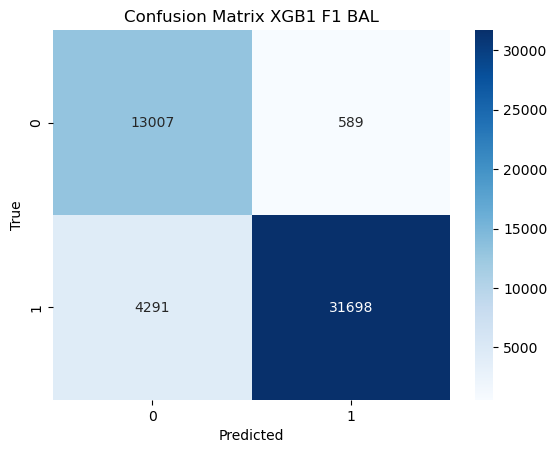

Classification Report - Modello 7
XGB2 A BAL
              precision    recall  f1-score   support

           0       0.63      0.87      0.73     13596
           1       0.94      0.81      0.87     35989

    accuracy                           0.82     49585
   macro avg       0.78      0.84      0.80     49585
weighted avg       0.85      0.82      0.83     49585

Confusion Matrix
[[11765  1831]
 [ 7007 28982]]


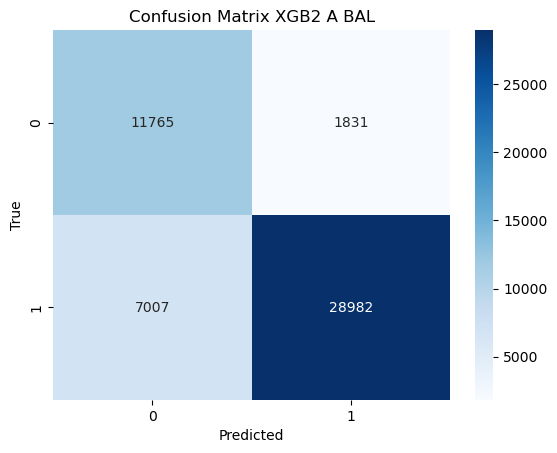

Classification Report - Modello 8
XGB2 F1 BAL
              precision    recall  f1-score   support

           0       0.63      0.87      0.73     13596
           1       0.94      0.81      0.87     35989

    accuracy                           0.82     49585
   macro avg       0.78      0.84      0.80     49585
weighted avg       0.85      0.82      0.83     49585

Confusion Matrix
[[11765  1831]
 [ 7007 28982]]


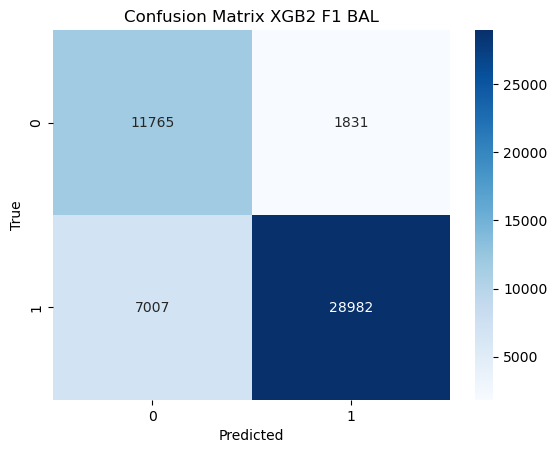

Classification Report - Modello 9
RF1 CV10 BAL
              precision    recall  f1-score   support

           0       0.63      0.87      0.73     13596
           1       0.94      0.81      0.87     35989

    accuracy                           0.82     49585
   macro avg       0.79      0.84      0.80     49585
weighted avg       0.86      0.82      0.83     49585

Confusion Matrix
[[11783  1813]
 [ 6902 29087]]


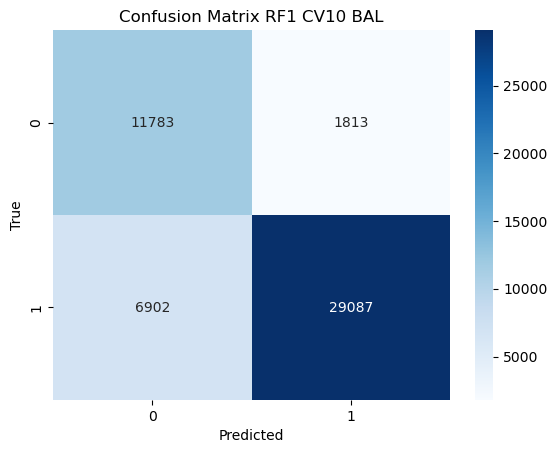

Classification Report - Modello 10
XGB F1 CV10 BAL
              precision    recall  f1-score   support

           0       0.63      0.87      0.73     13596
           1       0.94      0.81      0.87     35989

    accuracy                           0.82     49585
   macro avg       0.79      0.84      0.80     49585
weighted avg       0.86      0.82      0.83     49585

Confusion Matrix
[[11783  1813]
 [ 6902 29087]]


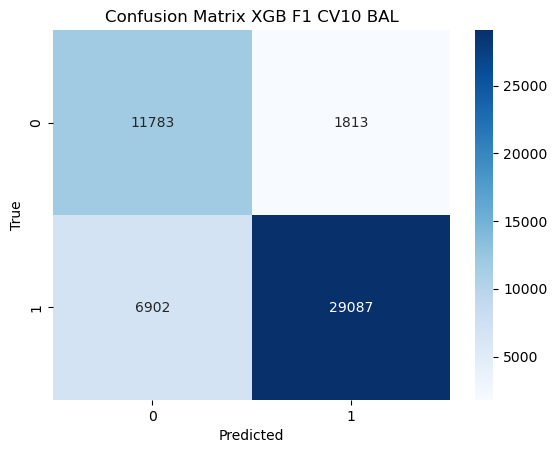

Classification Report - Modello 11
XGB F1 CV15 BAL
              precision    recall  f1-score   support

           0       0.63      0.87      0.73     13596
           1       0.94      0.81      0.87     35989

    accuracy                           0.82     49585
   macro avg       0.79      0.84      0.80     49585
weighted avg       0.86      0.82      0.83     49585

Confusion Matrix
[[11780  1816]
 [ 6938 29051]]


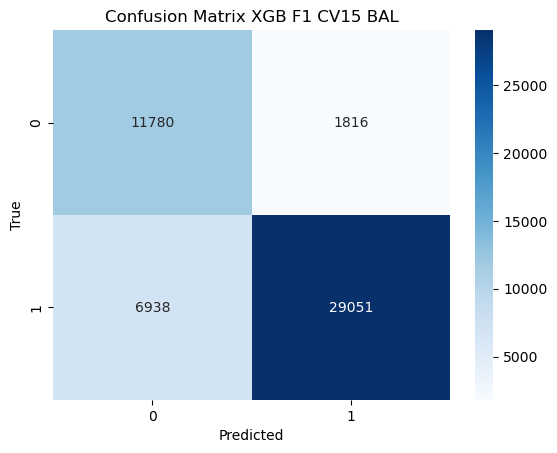

In [27]:
i = 0
for model in models_balanced_bin:

    predictions = model.predict(X_Test)

    # Calcolate and print the classification report
    report_Test = classification_report(concatenated_DF['Error'], predictions)

    print(f"Classification Report - model {i+1}\n{names_bal[i]}")
    print(report_Test)
    
    # CCalcolate and print the confusion matrix using seaborn
    confusion_mat = confusion_matrix(concatenated_DF['Error'], predictions)
    print("Confusion Matrix")
    print(confusion_mat)

    # Show confusion matrix
    plt.figure()
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {names_bal[i]}')
    plt.show()
    i+=1

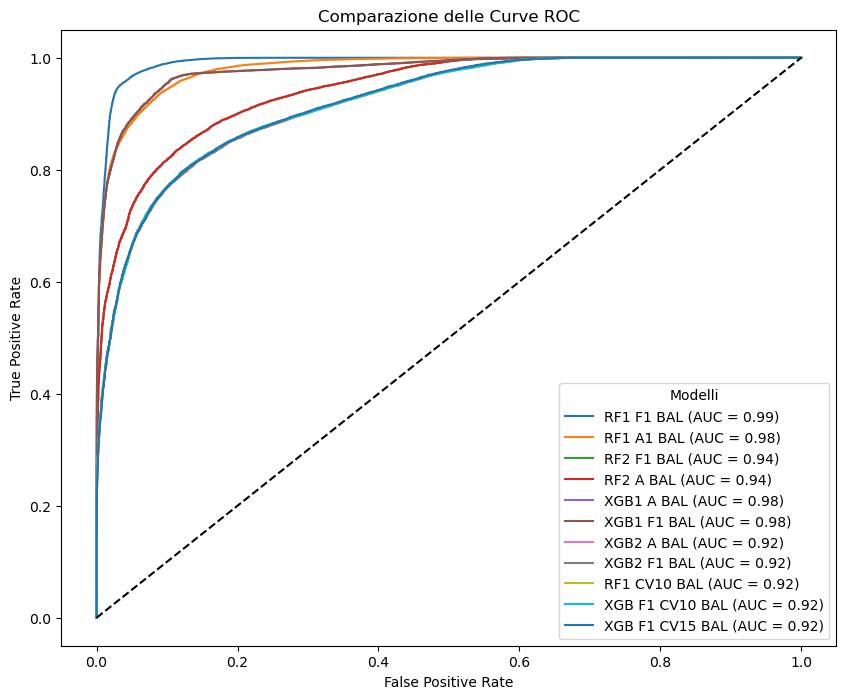

In [25]:
from sklearn.metrics import roc_curve, auc

model_names = []

plt.figure(figsize=(10, 8))

# Loop on the models
i = 0
for model in models_balanced_bin:
    # Predictions on the model
    y_proba = model.predict_proba(X_Test)[:, 1]

    # Calcolate FPR, TPR, e AUC
    fpr, tpr, thresholds = roc_curve(concatenated_DF['Error'], y_proba)
    roc_auc = auc(fpr, tpr)

   
    model_names.append(f"model {i+1} (AUC = {roc_auc:.2f})")

    plt.plot(fpr, tpr, label=f'{names_bal[i]} (AUC = {roc_auc:.2f})')
    i += 1

# Add casual line for reference
plt.plot([0, 1], [0, 1], 'k--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparazione delle Curve ROC')
plt.legend(title="models")

plt.show()
